d:\dev\mental_health\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



Dataset Overview:
Shape: (3512, 2)
Columns: ['Context', 'Response']

Sample data:
                                             Context  \
0  I'm going through some things with my feelings...   
1  I'm going through some things with my feelings...   
2  I'm going through some things with my feelings...   
3  I'm going through some things with my feelings...   
4  I'm going through some things with my feelings...   

                                            Response  
0  If everyone thinks you're worthless, then mayb...  
1  Hello, and thank you for your question and see...  
2  First thing I'd suggest is getting the sleep y...  
3  Therapy is essential for those that are feelin...  
4  I first want to let you know that you are not ...  

Missing values:
Context     0
Response    0
dtype: int64

Basic statistics:
Average Context Length: 282.65 characters
Average Response Length: 1026.07 characters
Min Context Length: 25 characters
Max Context Length: 2703 characters
Min Response Leng

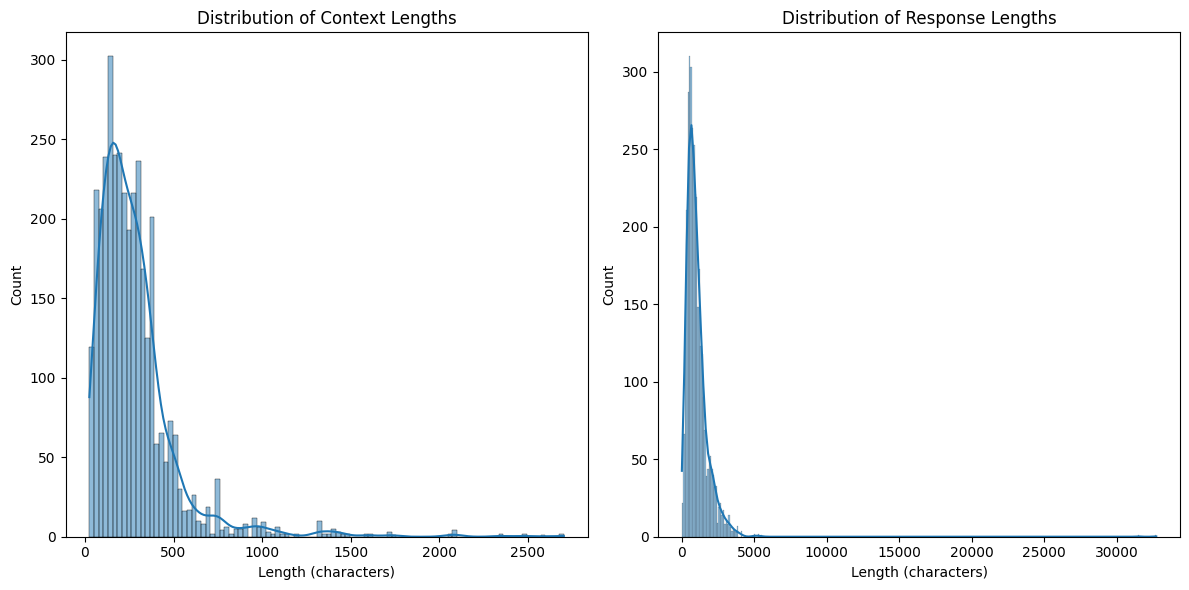

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from pathlib import Path

# Function to load and explore the dataset
def load_and_explore_dataset(file_path):
    # Load the dataset
    import pandas as pd

    df = pd.read_json("hf://datasets/Amod/mental_health_counseling_conversations/combined_dataset.json", lines=True)
    
    # Display basic information
    print("\nDataset Overview:")
    print(f"Shape: {df.shape}")
    print(f"Columns: {df.columns.tolist()}")
    
    # Display first few rows
    print("\nSample data:")
    print(df.head())
    
    # Check for missing values and drop them
    print("\nMissing values:")
    print(df.isnull().sum())

    # convert all columns to string
    df = df.astype(str)
    
    # Basic statistics
    print("\nBasic statistics:")
    df['Context_Length'] = df['Context'].apply(len)
    df['Response_Length'] = df['Response'].apply(len)
    
    print(f"Average Context Length: {df['Context_Length'].mean():.2f} characters")
    print(f"Average Response Length: {df['Response_Length'].mean():.2f} characters")
    print(f"Min Context Length: {df['Context_Length'].min()} characters")
    print(f"Max Context Length: {df['Context_Length'].max()} characters")
    print(f"Min Response Length: {df['Response_Length'].min()} characters")
    print(f"Max Response Length: {df['Response_Length'].max()} characters")

    # Visualize length distributions
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    sns.histplot(df['Context_Length'], kde=True)
    plt.title('Distribution of Context Lengths')
    plt.xlabel('Length (characters)')
    
    plt.subplot(1, 2, 2)
    sns.histplot(df['Response_Length'], kde=True)
    plt.title('Distribution of Response Lengths')
    plt.xlabel('Length (characters)')
    
    plt.tight_layout()
    plt.savefig('length_distributions.png')
    
    return df

# Function to clean the dataset
def clean_dataset(df):
    print("Cleaning dataset...")
    
    # Make a copy of the original dataframe
    clean_df = df.copy()
    
    original_count = len(clean_df)

    # Handle missing values
    clean_df = clean_df.dropna()
    print(f"Removed {original_count - len(clean_df)} rows with missing values")
    
    # Clean text data
    def clean_text(text):
        if isinstance(text, str):
            # Remove extra whitespace
            text = re.sub(r'\s+', ' ', text)
            # Remove leading/trailing whitespace
            text = text.strip()
            return text
        return ""
    
    clean_df['Context'] = clean_df['Context'].apply(clean_text)
    clean_df['Response'] = clean_df['Response'].apply(clean_text)
    
    # Filter out very short conversations
    min_context_length = 10  # characters
    min_response_length = 10  # characters
    
    original_count = len(clean_df)
    clean_df = clean_df[(clean_df['Context'].str.len() >= min_context_length) & 
                        (clean_df['Response'].str.len() >= min_response_length)]
    
    print(f"Filtered out {original_count - len(clean_df)} rows with very short text")
    
    # Reset index after filtering
    clean_df = clean_df.reset_index(drop=True)
    
    # Create conversation IDs
    clean_df['ConversationID'] = range(1, len(clean_df) + 1)
    
    # Reorder columns to put ID first
    clean_df = clean_df[['ConversationID', 'Context', 'Response', 'Context_Length', 'Response_Length']]
    
    return clean_df

# Function to save the cleaned dataset
def save_cleaned_dataset(df, output_path):
    # Create directory if it doesn't exist
    output_dir = Path(output_path).parent
    output_dir.mkdir(parents=True, exist_ok=True)
    
    # Save to CSV
    df.to_csv(output_path, index=False)
    print(f"Cleaned dataset saved to {output_path}")
    
    # Also save a version without the length columns for further processing
    df_final = df[['ConversationID', 'Context', 'Response']]
    final_path = str(output_path).replace('.csv', '_final.csv')
    df_final.to_csv(final_path, index=False)
    print(f"Final dataset (without length columns) saved to {final_path}")

# Main execution
def main():
    # Set file paths
    input_file = "data/mental_health_conversations.csv"  # Update this with the actual file name
    output_file = "data/cleaned_conversations.csv"
    
    # Execute the pipeline
    df = load_and_explore_dataset(input_file)
    cleaned_df = clean_dataset(df)
    save_cleaned_dataset(cleaned_df, output_file)
    
    # Print summary
    print("\nData Processing Summary:")
    print(f"Original dataset: {len(df)} conversations")
    print(f"Cleaned dataset: {len(cleaned_df)} conversations")
    print(f"Reduction: {len(df) - len(cleaned_df)} conversations ({((len(df) - len(cleaned_df)) / len(df) * 100):.2f}%)")

if __name__ == "__main__":
    main()